<a href="https://colab.research.google.com/github/pedroconcejero/CA_elecc_20D/blob/master/%5BPrivate%5D%5BU_tad%5D_Basic_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'private-u-tad-dogs-vs-cats-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F85781%2F9710566%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T144458Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D42ed9882689f3912b88116bc71e9ca8a3b1f509bbc37b14c538d0023b59c91c219555ac608b9c4d4dd13cbec91a88e9c32c511132015e44e5380914c74aa286238069528c514aaa58b9007b56acad615d484fe49751a3e7993794bac85d4b3e10fb0fc9880cff55f3708f16d5c6f46b0260490d33822e8a87a6092e6b37d728d1cdda9bbc56a36f6e64583c69eb14adb515985ac0ae2356d8769afc5d564c4ecf97665071c40df8b3c0ef3ebf7b6edc36d1887c4a372384dba4697ca8a337593a8b660433067ae291692756c278698e03ded7c60c9f420f9b6864d6d9ea2a05146f8cb9e49af5b93020fc3ffca1f9e79d2f21cad441b7e7a4262d0f24c2dd26d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import data as tf_data
import keras

seed = 1
keras.utils.set_random_seed(seed)

### Read in the training data

In [ ]:
image_size = (256, 256)

# when working with 20_000 files for training this
# will lead to exactly 160 mini-batches per epoch
batch_size = 125

# https://keras.io/api/data_loading/image/#imagedatasetfromdirectory-function

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    #"PetImages",
    "/kaggle/input/private-u-tad-dogs-vs-cats-2024/train/train",
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


### A basic sequential CNN model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

input_shape = image_size + (3,)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape = input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,077,186 (225.36 MB)

 Trainable params: 59,077,186 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile and train (fit)

In [ ]:
%%time

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001,
                                                 momentum=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 12

history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = epochs,)

Epoch 1/12


I0000 00:00:1728916060.405796     100 service.cc:145] XLA service 0x7ff290002540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728916060.405866     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-10-14 14:27:49.301891: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[125,32,127,127]{3,2,1,0}, f32[125,64,125,125]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-14 14:27:50.149251: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.847492272s
Trying algorithm eng0{} for conv (f32[64,3

  1/160 ━━━━━━━━━━━━━━━━━━━━ 34:30 13s/step - accuracy: 0.5040 - loss: 10.2328

I0000 00:00:1728916071.882982     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 60s 298ms/step - accuracy: 0.5605 - loss: 1430.2374 - val_accuracy: 0.5902 - val_loss: 0.6827
Epoch 2/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.5393 - loss: 1.7532 - val_accuracy: 0.5506 - val_loss: 0.7258
Epoch 3/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.5672 - loss: 2.8363 - val_accuracy: 0.6180 - val_loss: 0.6674
Epoch 4/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.5732 - loss: 3.7049 - val_accuracy: 0.5290 - val_loss: 0.6774
Epoch 5/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.5441 - loss: 0.7794 - val_accuracy: 0.6210 - val_loss: 0.6589
Epoch 6/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.6823 - loss: 0.6207 - val_accuracy: 0.7498 - val_loss: 0.5266
Epoch 7/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7429 - loss: 0.5346 - val_accuracy: 0.7662 - val_loss: 0.5007
Epoch 8/12
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7898 - loss: 0.4585 - 

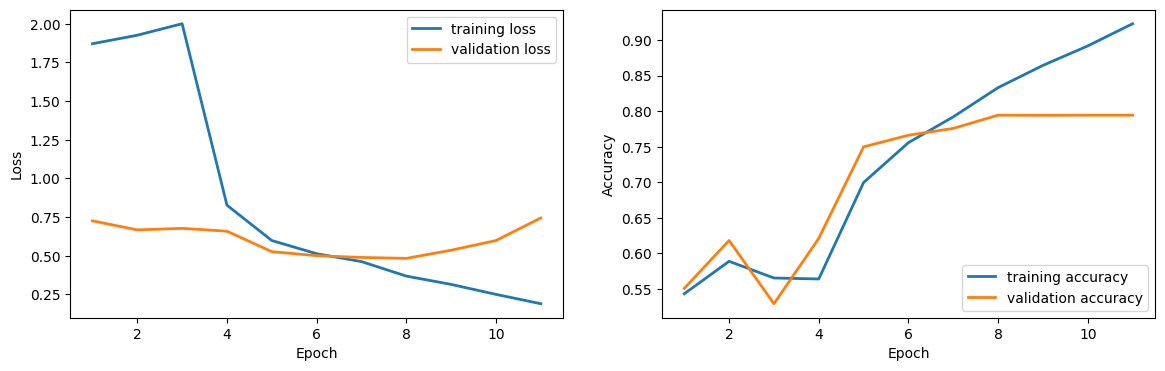

In [ ]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[1:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[1:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[1:,"accuracy"], lw=2, label='training accuracy')
plt.plot(logs.loc[1:,"val_accuracy"], lw=2, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

### Create predictions for all test images

In [ ]:
%%time

folder_path = "/kaggle/input/private-u-tad-dogs-vs-cats-2024/test/test/"

discrimination_threshold = 0.5  # below 0.5 is a cat, above 0.5 is a dog
predictions_dict = {}

for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)

    # save the image name
    file_name = img.split('/')[-1]
    file_no_extension = file_name.split('.')[0]

    img = keras.utils.load_img(img, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)
    predictions = model.predict(img_array, verbose=None)
    score = predictions[0][1]
    label = (score > discrimination_threshold )*1

    # save the predictions to a dictionary
    predictions_dict[int(file_no_extension)] = label

CPU times: user 1min 58s, sys: 11.4 s, total: 2min 9s
Wall time: 2min 36s


### Save predictions to a competition submission file

In [ ]:
submission = pd.DataFrame(predictions_dict.items(), columns=["id", "label"]).sort_values(by='id', ascending=True)
submission.to_csv('submission.csv',index=False)

# print numbers of each class label
submission["label"].value_counts()

label
1    541
0    526
Name: count, dtype: int64

In [ ]:
submission

,id,label
292,1,0
1031,2,1
863,3,0
830,4,1
78,5,1
...,...,...
712,1063,1
525,1064,1
951,1065,0
470,1066,1
